# Enzymology Homework

### Student: Artem Fadeev

### Professor: Vojtěch Spiwok

#### Date: 16.3.2025

In [3]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data
df = pd.read_csv('data63.txt', sep=r'\s+', names=['Substrate', 'Inhibitor', 'Rate'], header=None)

# Separate inhibited and uninhibited data
no_inhibitor = df[df['Inhibitor'] == 0]
with_inhibitor = df[df['Inhibitor'] > 0]

In [4]:
df

,Substrate,Inhibitor,Rate
0,1.0,0.0,0.24
1,2.0,0.0,0.39
2,3.0,0.0,0.49
3,4.0,0.0,0.55
4,5.0,0.0,0.61
5,1.0,1.0,0.04
6,2.0,1.0,0.06
7,3.0,1.0,0.08
8,4.0,1.0,0.09
9,5.0,1.0,0.10


### 1. Michaelis-Menten Function
The Michaelis-Menten equation describes the rate of enzymatic reactions by relating reaction rate (V) to substrate concentration (S).

It is given by the formula:

$$V = \frac{V_{max} \cdot [S]}{K_m + [S]}$$
 
where:
-  $ V $  is the reaction rate
- $ V_{max} $ is the maximum reaction rate
- $[S]$ is the substrate concentration
- $ K_m $ is the Michaelis constant, representing the substrate concentration at half $ V_{max} $


In [6]:
# Michaelis-Menten function
def michaelis_menten(S, Vmax, Km):
    """Michaelis-Menten equation."""
    return (Vmax * S) / (Km + S)

### 2. Parameter Estimation Without Inhibitor
We fit the Michaelis-Menten equation to experimental data without an inhibitor using non-linear curve fitting.

In this section, we estimate the kinetic parameters  $V_{max}$  and  $K_m$  for the enzyme in the absence of an inhibitor. The Michaelis-Menten equation is fitted to the experimental data using non-linear curve fitting. This process finds the best-fit values of  $V_{max}$  and  $K_m$  by minimizing the difference between the observed reaction rates and those predicted by the equation.

Why We Do This:
- Determine Baseline Kinetics: Understanding enzyme behavior without an inhibitor provides a reference point for comparing inhibited reactions.
    
- Extract Key Parameters:
    
	•	 $V_{max}$  (maximum reaction rate) tells us the enzyme’s efficiency when saturated with the substrate.


	•	 $K_m$  (Michaelis constant) indicates how strongly the enzyme binds to the substrate; a lower  $K_m$  means higher affinity.


In [8]:
# Fit data without inhibitor
params_no_inhib, _ = opt.curve_fit(michaelis_menten, no_inhibitor['Substrate'], no_inhibitor['Rate'])
Vmax_no_inhib, Km_no_inhib = params_no_inhib

print(f"Without Inhibitor: Vmax = {Vmax_no_inhib:.3f}, Km = {Km_no_inhib:.3f}")

Without Inhibitor: Vmax = 0.976, Km = 3.028


 ### 3. Competitive Inhibition Model
 In competitive inhibition, the inhibitor competes with the substrate for the active site, affecting Km but not Vmax.
 The modified equation is:
 $$ V = \frac{V_{max} \cdot [S]}{K_m \left(1 + \frac{[I]}{K_i}\right) + [S]} $$
 where:
 - $ [I] $ is the inhibitor concentration
 - $ K_i $ is the inhibition constant, describing inhibitor binding affinity

In [10]:
# Competitive inhibition: Km is affected, Vmax is constant
def competitive_inhibition(S, Vmax, Km, Ki, I):
    return (Vmax * S) / (Km * (1 + I / Ki) + S)

# Fit the competitive inhibition model to the experimental data with inhibitor.
params_inhib, _ = opt.curve_fit(
    lambda S, Vmax, Km, Ki: competitive_inhibition(S, Vmax, Km, Ki, with_inhibitor['Inhibitor'].iloc[0]),
    with_inhibitor['Substrate'],
    with_inhibitor['Rate'],
    p0=[Vmax_no_inhib, Km_no_inhib, 1]  # Initial guesses based on uninhibited values
)

Vmax_inhib, Km_inhib, Ki = params_inhib

print(f"With Inhibitor: Vmax = {Vmax_inhib:.3f}, Km = {Km_inhib:.3f}, Ki = {Ki:.3f}")

With Inhibitor: Vmax = 0.166, Km = 3.307, Ki = 308.291


 ### 4. Lineweaver-Burk Plot
 The Lineweaver-Burk transformation is a double reciprocal plot used to determine kinetic parameters and distinguish inhibition types.

 The transformation is given by:
 $$ \frac{1}{V} = \frac{K_m}{V_{max} \cdot [S]} + \frac{1}{V_{max}} $$


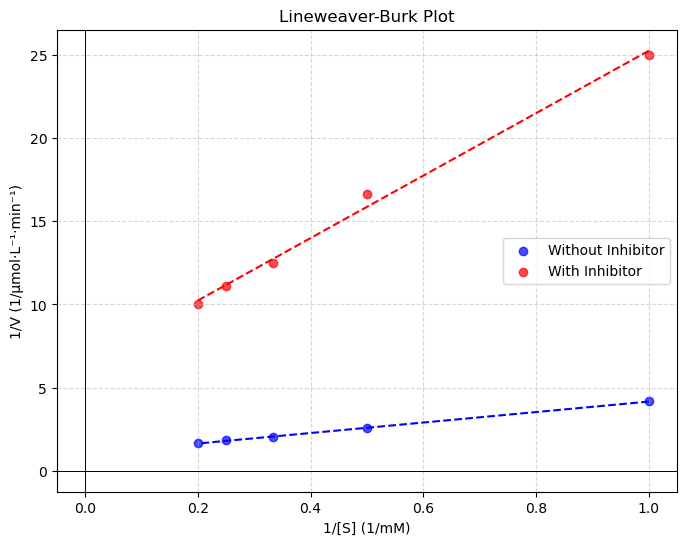

In [12]:
df = pd.concat([no_inhibitor.assign(Type='Without Inhibitor'), with_inhibitor.assign(Type='With Inhibitor')], ignore_index=True)  # Combine data for visualization
inv_substrate = 1 / df['Substrate']
inv_rate = 1 / df['Rate']

plt.figure(figsize=(8,6))
for label, color in zip(['Without Inhibitor', 'With Inhibitor'], ['blue', 'red']):
    subset = df[df['Type'] == label]
    plt.scatter(1 / subset['Substrate'], 1 / subset['Rate'], label=label, color=color, alpha=0.7)
    
    # Fit a linear regression line for each condition
    slope, intercept = np.polyfit(1 / subset['Substrate'], 1 / subset['Rate'], 1)
    plt.plot(1 / subset['Substrate'], slope * (1 / subset['Substrate']) + intercept, color=color, linestyle='--')

plt.xlabel('1/[S] (1/mM)')
plt.ylabel('1/V (1/µmol·L⁻¹·min⁻¹)')
plt.title('Lineweaver-Burk Plot')
plt.axhline(0, color='black', linewidth=0.7)
plt.axvline(0, color='black', linewidth=0.7)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Conclusion

The results indicate competitive inhibition, as seen in the increased Km (from 3.028 to 3.307) and significantly reduced Vmax (from 0.976 to 0.166). The inhibition constant Ki was determined to be 308.291.

These findings are consistent with competitive inhibition, where the inhibitor binds to the active site and increases the apparent Km, indicating a lower substrate affinity, while Vmax remains theoretically unchanged. However, in this case, the observed Vmax is significantly lower, which could suggest additional factors affecting the enzyme’s activity, such as partial inhibition or experimental limitations.

The Lineweaver-Burk plot confirms these changes, showing a steeper slope for the inhibited reaction. This suggests reduced substrate affinity while potentially maintaining Vmax in ideal conditions.